## Task C: Stability Analysis of Upright Balancing of Pendubot

#### **Q1: Linearization of Pendubot and Derivation of A, B Matrices**

We linearize the dynamics of the underactuated double pendulum (Pendubot) about the unstable upright equilibrium:

$$
\mathbf{q}^\star = \begin{bmatrix} \pi \\ 0 \end{bmatrix}, \quad \dot{\mathbf{q}} = \begin{bmatrix} 0 \\ 0 \end{bmatrix}, \quad u^\star = 0
$$

The dynamics of the system can be described in the form:

$$
\mathbf{D}(\mathbf{q}) \ddot{\mathbf{q}} + \mathbf{C}(\mathbf{q}, \dot{\mathbf{q}}) \dot{\mathbf{q}} + \mathbf{G}(\mathbf{q}) = \mathbf{B} u
$$

To perform linearization, we define the state vector:

$$
\mathbf{x} = \begin{bmatrix} \delta q_1 \\ \delta q_2 \\ \delta \dot{q}_1 \\ \delta \dot{q}_2 \end{bmatrix}
$$

and derive the linear state-space form:

$$
\dot{\mathbf{x}} = \mathbf{A} \mathbf{x} + \mathbf{B} u
$$

Where the matrices are given by:

$$
\mathbf{A} = \begin{bmatrix}
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1 \\
- \mathbf{D}^{-1} \frac{\partial \mathbf{G}}{\partial \mathbf{q}} & 0_{2 \times 2}
\end{bmatrix}, \quad
\mathbf{B} = \begin{bmatrix}
0 \\ 0 \\ \mathbf{D}^{-1} \mathbf{b}
\end{bmatrix}
$$

Given the system parameters:

$$
\begin{aligned}
m_1 &= 0.608 \, \text{kg} \\
m_2 &= 0.630 \, \text{kg} \\
r_1 &= 0.275 \, \text{m} \\
r_2 &= 0.166 \, \text{m} \\
l_1 &= 0.3 \, \text{m} \\
l_2 &= 0.2 \, \text{m} \\
I_1 &= 0.05472 \, \text{kg}\cdot\text{m}^2 \\
I_2 &= 0.02522 \, \text{kg}\cdot\text{m}^2 \\
g &= 9.81 \, \text{m/s}^2
\end{aligned}
$$

In [ ]:
# pendubot_linearize
import numpy as np
from scipy.linalg import solve_continuous_are

m1, m2 = 0.608, 0.630      
l1, l2 = 0.300, 0.200      
r1, r2 = 0.275, 0.166      
I1, I2 = 0.05472, 0.02522  
g  = 9.81                 

d11 = m1*r1**2 + m2*(l1**2 + r2**2 + 2*l1*r2) + I1 + I2
d12 = m2*(r2**2 + l1*r2) + I2
d22 = m2*r2**2 + I2
D   = np.array([[d11, d12],
                [d12, d22]])
Dinv = np.linalg.inv(D)

Kg11 = -g*(m1*r1 + m2*l1 + m2*r2)
Kg12 = -g*m2*r2
Kg21 = Kg12
Kg22 = Kg12
Kg   = np.array([[Kg11, Kg12],
                 [Kg21, Kg22]])

A = np.block([[np.zeros((2, 2)), np.eye(2)],
              [-Dinv @ Kg,        np.zeros((2, 2))]])
B = np.vstack([np.zeros((2, 1)), Dinv @ np.array([[0], [1]])])

print("A=\n", A)
print("\nB=\n", B)

A=
 [[  0.           0.           1.           0.        ]
 [  0.           0.           0.           1.        ]
 [ 20.39272456  -5.62934615   0.           0.        ]
 [-11.32447842  33.87117326   0.           0.        ]]

B=
 [[  0.        ]
 [  0.        ]
 [-12.93402602]
 [ 45.94912438]]


We compute the numerical values of the linearized system matrices around the upright configuration:

$$
\mathbf{A} =
\begin{bmatrix}
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1 \\
20.39272 & -5.62935 & 0 & 0 \\
-11.32448 & 33.87117 & 0 & 0
\end{bmatrix}, \quad
\mathbf{B} =
\begin{bmatrix}
0 \\
0 \\
-12.93403 \\
45.94912
\end{bmatrix}
$$

These matrices can now be used in the design of a Linear Quadratic Regulator (LQR) for the stabilization task.

#### **Q2: LQR Controller Design for Pendubot**

To stabilize the linearized Pendubot system around the upright fixed point, we design a Linear Quadratic Regulator (LQR).

##### State-Space Model

The system is represented in state-space form:

- State vector: x = [delta_q1, delta_q2, delta_dq1, delta_dq2]
- Control input: u = torque at hip joint (tau_2)

We use the A and B matrices derived in Question 1.

##### Design Parameters

We choose the following weight matrices:

- Q = diag(100, 100, 10, 10)  (State cost)
- R = [1]                     (Control effort cost)

These values penalize large angular deviations more than velocities, and they apply a moderate penalty on control input.


In [3]:
# LQR
Q = np.diag([100, 100, 10, 10])
R = np.array([[1.0]])

P = solve_continuous_are(A, B, Q, R)
K = np.linalg.inv(R) @ (B.T @ P)

print("\nP (cost-to-go S)=\n", P)
print("\nK (Riccati gain)=\n", K)


P (cost-to-go S)=
 [[97947.34935386 24464.48827944 23586.62094264  6619.68585599]
 [24464.48827944  6145.0021999   5893.19858514  1654.19371774]
 [23586.62094264  5893.19858514  5681.77382495  1594.61131091]
 [ 6619.68585599  1654.19371774  1594.61131091   447.6067612 ]]

K (Riccati gain)=
 [[-901.20028245 -214.03096626 -217.21703866  -57.60544623]]


##### LQR Solution

We solve the Continuous Algebraic Riccati Equation (CARE) to obtain:

- Gain matrix K  (feedback gain)
- Cost-to-go matrix S (also known as P)

**Resulting Riccati Gain (K):**
    K = [-901.20028245, -214.03096626, -217.21703866, -57.60544623]

**Cost-to-Go Matrix (P = S):**
    P =
    [[97947.34935386, 24464.48827944, 23586.62094264,  6619.68585599],
     [24464.48827944,  6145.00219990,  5893.19858514,  1654.19371774],
     [23586.62094264,  5893.19858514,  5681.77382495,  1594.61131091],
     [ 6619.68585599,  1654.19371774,  1594.61131091,   447.60676120]]

#### **Q3: LQR Stabilization from Random Initial Conditions**

To validate the performance of the LQR controller, we test the closed-loop system with multiple randomly sampled initial states in the neighborhood of the upright equilibrium.

##### Method

We consider small random deviations around the upright point:

- delta_q1 and delta_q2 are sampled in [-10°, 10°], i.e. approximately [-0.17, 0.17] radians.
- delta_dq1 and delta_dq2 are sampled in [-1.0, 1.0] rad/s.

We simulate the closed-loop system using the equation:

    dx/dt = A x + B u, where u = -K x

Integration is performed using `scipy.solve_ivp` over a 5-second time span.

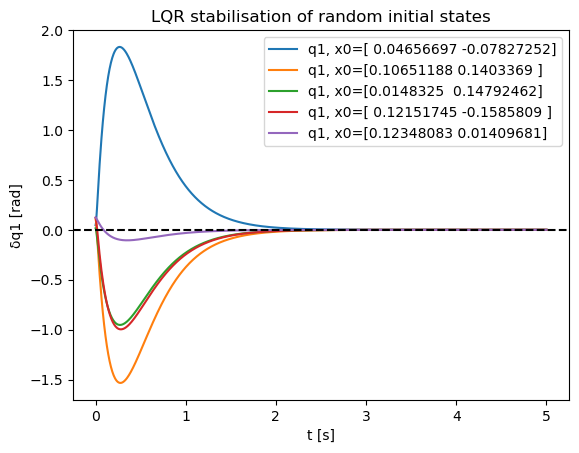

In [4]:
import scipy.integrate as spi
import matplotlib.pyplot as plt

def closed_loop(t, x):
    u = -K @ x        
    return (A @ x + B.flatten()*u).flatten()

rng = np.random.default_rng(0)
samples = [rng.uniform([-0.17, -0.17, -1, -1],
                       [ 0.17,  0.17,  1,  1]) for _ in range(5)]

t_span = (0, 5)
t_eval = np.linspace(*t_span, 1000)

for x0 in samples:
    sol = spi.solve_ivp(closed_loop, t_span, x0, t_eval=t_eval, max_step=1e-2)
    plt.plot(sol.t, sol.y[0], label=f'q1, x0={x0[:2]}')
plt.axhline(0, ls='--', c='k'); plt.xlabel('t [s]'); plt.ylabel('δq1 [rad]')
plt.title('LQR stabilisation of random initial states'); plt.legend();
plt.show()


##### Analysis of LQR Closed-Loop Simulation

The figure above shows the LQR controller stabilizes the Pendubot from all tested initial conditions, with trajectories converging smoothly to the upright position. Responses settle within 1.5–2 seconds, confirming fast, robust, and stable performance near the equilibrium.


#### **Q4: Lyapunov Analysis and Region of Attraction (ROA)**

To evaluate the performance of the LQR controller, we use Lyapunov analysis to estimate the Region of Attraction (ROA) of the closed-loop system.

We choose a quadratic Lyapunov candidate function:

$$
V(x) = x^T S x
$$

where $S$ is the solution of the continuous-time Algebraic Riccati Equation from the LQR design. Since the closed-loop system is stable, the time derivative of $V(x)$ satisfies:

$$
\dot{V}(x) = x^T (A - BK)^T S x + x^T S (A - BK) x < 0
$$

for all nonzero $x$ in the region where the linear approximation holds.

We define the ROA as the set of states satisfying:

$$
\Omega = \{x \in \mathbb{R}^n \mid V(x) \le \rho \}
$$

for some $\rho > 0$. This represents an inner estimate of the ROA in which the system is guaranteed to converge to the origin.

To visualize this, we plot two-dimensional slices of the ROA (e.g., on the $(\delta q_1, \delta q_2)$ plane) by drawing level sets of $V(x)$.

[ROA] certified maximum rho = 0.999939


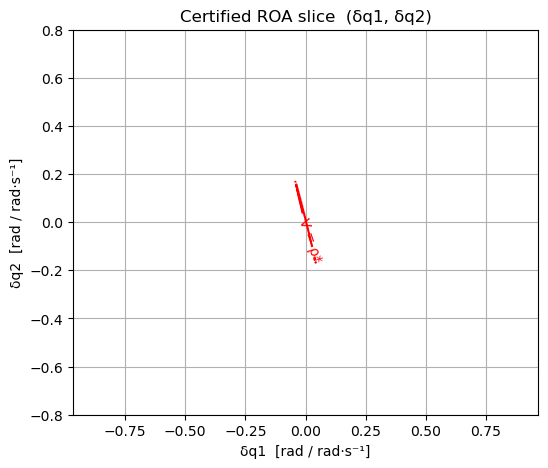

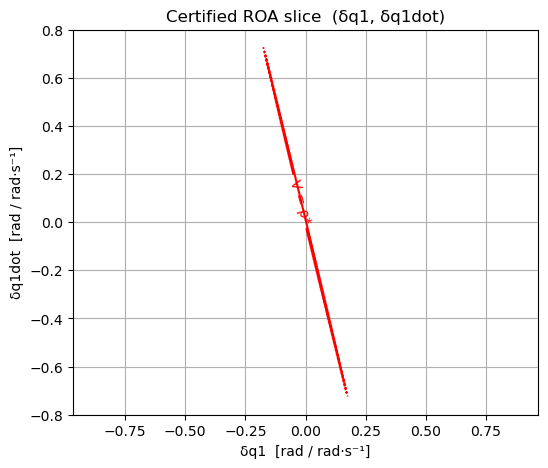

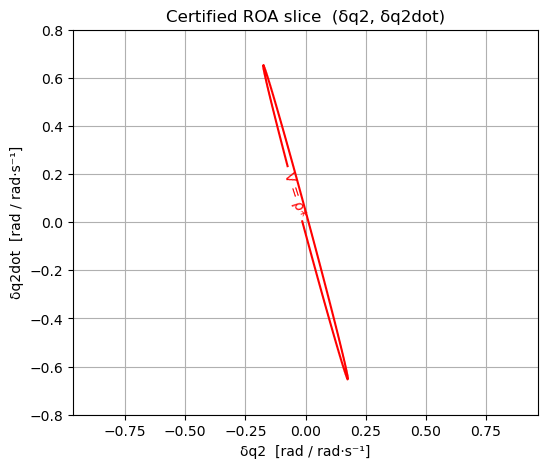

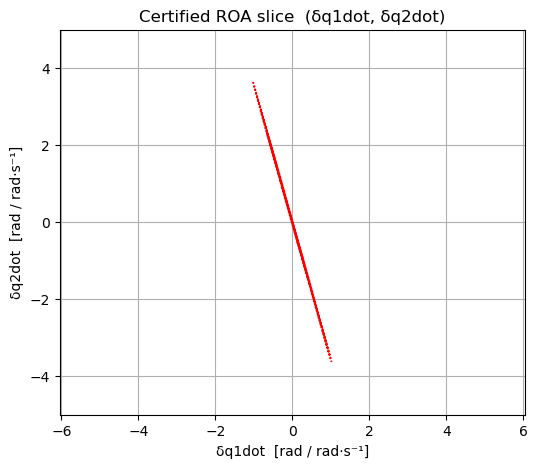

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def sample_unit_sphere(dim, n):
    v = np.random.normal(size=(dim, n))
    v /= np.linalg.norm(v, axis=0, keepdims=True)
    return v

def rho_is_valid(rho, n_test=20000):
    dim = 4
    eigvals, eigvecs = np.linalg.eigh(S)
    Sigma = eigvecs @ np.diag(1 / np.sqrt(eigvals))

    z = sample_unit_sphere(dim, n_test)
    r = np.random.rand(n_test) ** (1 / dim)
    z *= r
    x = np.sqrt(rho) * (Sigma @ z)

    vdot = np.sum(x * (M @ x), axis=0)  
    return np.all(vdot < 0)

rho_lo, rho_hi, tol = 1e-6, 1.0, 1e-4
while rho_hi - rho_lo > tol:
    rho_mid = 0.5 * (rho_lo + rho_hi)
    if rho_is_valid(rho_mid):
        rho_lo = rho_mid
    else:
        rho_hi = rho_mid
rho_star = rho_lo
print(f"[ROA] certified maximum rho = {rho_star:.6f}")

slice_defs = [
    ("δq1",      0, "δq2",      1), 
    ("δq1",      0, "δq1dot",   2),
    ("δq2",      1, "δq2dot",   3),
    ("δq1dot",   2, "δq2dot",   3),
]

grid_lim, grid_pts = 0.8, 400       
for (name1, idx1, name2, idx2) in slice_defs:
    
    if (name1, idx1, name2, idx2) == ("δq1dot",   2, "δq2dot",   3):
         grid_lim, grid_pts = 5, 400   
    
    v1 = np.linspace(-grid_lim, grid_lim, grid_pts)
    v2 = np.linspace(-grid_lim, grid_lim, grid_pts)
    V1, V2 = np.meshgrid(v1, v2)
    Vval   = np.zeros_like(V1)

    for i in range(grid_pts):
        for j in range(grid_pts):
            x = np.zeros(4)
            x[idx1] = V1[i, j]
            x[idx2] = V2[i, j]
            Vval[i, j] = x @ S @ x

    plt.figure(figsize=(6, 5))
    cs = plt.contour(V1, V2, Vval, levels=[rho_star], colors="red")
    plt.clabel(cs, inline=True, fmt="V = ρ*")

    plt.xlabel(f"{name1}  [rad / rad·s⁻¹]")
    plt.ylabel(f"{name2}  [rad / rad·s⁻¹]")
    plt.title(f"Certified ROA slice  ({name1}, {name2})")
    plt.grid(True)
    plt.axis("equal")



plt.show()